In [47]:
import os,time,sys
import matplotlib.pyplot as plt 
import numpy as np
from charon import propa
import charon.physicsconstants as PC
pc = PC.PhysicsConstants()
from Spectra_functions import Spectra_generator, Spectra_interpolation, Flux_generator, J_interpolation, Flux_interpolation, Signal_PDF
from scipy.interpolate import splrep, splev
from ipynb.fs.full.func_plot_histo import plot_projections
import random as rd

Initial Flux Loading: /usr/local/lib/python3.10/dist-packages/charon-0.1.0-py3.10.egg/charon/data/SpectraEW.hdf5


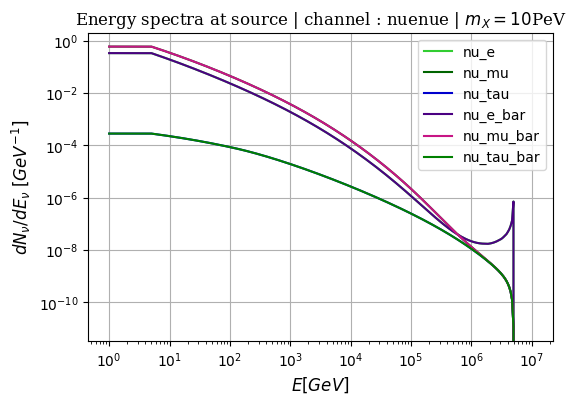

In [48]:
Flux_nue = Spectra_generator(mass = 1e7, channel = 'nuenue', process='decay')

In [49]:
resp_matrix_data = np.load('Response matrix/Resp_MC1122_logE.pkl',allow_pickle=True, encoding="latin1")

In [50]:
True_energy_center = resp_matrix_data['Bin']['true_energy_center']
True_psi_center = resp_matrix_data['Bin']['true_psi_center']
Reco_energy_center = resp_matrix_data['Bin']['reco_energy_center']
Reco_psi_center = resp_matrix_data['Bin']['reco_psi_center']

Initial Flux Loading: /usr/local/lib/python3.10/dist-packages/charon-0.1.0-py3.10.egg/charon/data/SpectraEW.hdf5
Initial Flux Loading: /usr/local/lib/python3.10/dist-packages/charon-0.1.0-py3.10.egg/charon/data/SpectraEW.hdf5


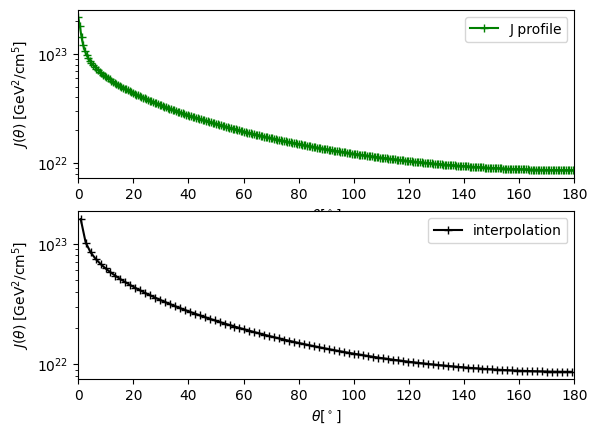

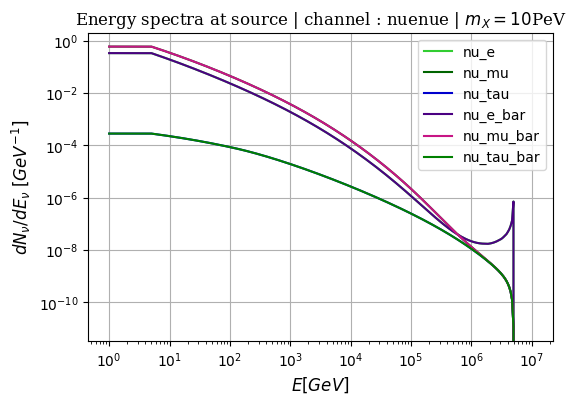

In [51]:
True_flux_nue = Flux_interpolation(mass=1e7,channel='nuenue',process='decay', theta_true_center=True_psi_center, E_true_center=True_energy_center, extrapolation=False)  

In [52]:
Resp = resp_matrix_data['Resp']

theta = np.linspace(0.,np.pi,100)
mass_range = Flux_nue.iniE()
theta_edges = np.histogram_bin_edges(theta,bins=len(theta))
mass_range_edges = np.histogram_bin_edges(mass_range,bins=len(mass_range))
Reco_mass_edges = np.histogram_bin_edges(Reco_energy_center,bins=len(Reco_energy_center))
Reco_theta_edges = np.histogram_bin_edges(Reco_psi_center,bins=len(Reco_psi_center))

In [53]:
grid = np.meshgrid(True_psi_center, True_energy_center, Reco_psi_center, Reco_energy_center, indexing='ij')
RecoRate_nue = np.zeros((len(Reco_psi_center),len(Reco_energy_center)))
RecoRate_numu = np.zeros((len(Reco_psi_center),len(Reco_energy_center)))
RecoRate_nutau = np.zeros((len(Reco_psi_center),len(Reco_energy_center)))

for i, nu_flavor in enumerate(Resp.keys()):
    TotalWeight = np.sum(Resp[nu_flavor])
    dRdlogE=Resp[nu_flavor]*grid[1]
    RespPdf = dRdlogE/np.sum(dRdlogE)
    RecoRate_nue += np.tensordot(RespPdf*TotalWeight, True_flux_nue[i], axes=([0,1], [1,0]))

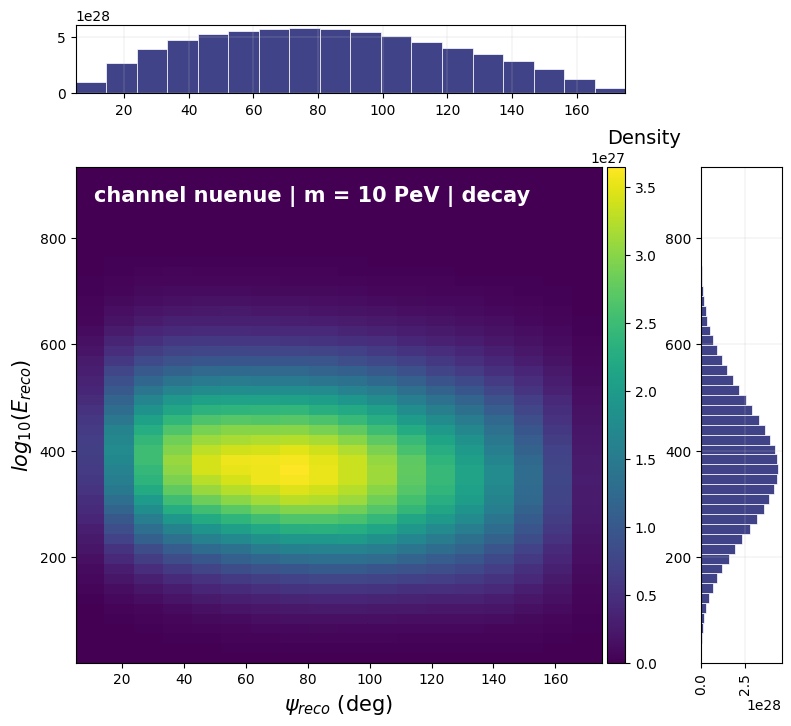

In [54]:
plot_projections(RecoRate_nue,(Reco_theta_edges,Reco_mass_edges),'$\psi_{reco}$ (deg)','$log_{10}(E_{reco})$','channel nuenue | m = 10 PeV | decay')

In [55]:
data = np.load('Burnsample/OscNext_Level7_v02.00_burnsample_2020_pass2_variables_NoCut.pkl',allow_pickle=True, encoding="latin1")

In [56]:
burnsample = data['burnsample']

In [57]:
def psi_f(RA,decl):
    return np.arccos(np.cos(np.pi/2.-(-29.0078*np.pi/180))*np.cos(np.pi/2.-decl)\
                      +np.sin(np.pi/2.-(-29.0078*np.pi/180))*np.sin(np.pi/2.-decl)*\
                       np.cos(RA-266.4168*np.pi/180))

In [58]:
DEC_reco = burnsample['reco_Dec']
RA_reco = burnsample['reco_RA']
psi_reco = burnsample['reco_psi']
E_reco = burnsample['reco_TotalEnergy']

In [59]:
for i in range(1):
    psi = psi_f(RA_reco[i], DEC_reco[i])
    print('psi computed = {0} ; psi_reco = {1} \n'.format(psi, psi_reco[i]))

psi computed = 2.7251981640916982 ; psi_reco = 2.725196713406548 



In [60]:
RA_random_oversample = []
DEC_oversample = []
E_reco_oversample = []

for i in range(len(DEC_reco)):
    for j in range(10):
        RA_random_oversample.append(rd.randint(0,360))
        DEC_oversample.append(DEC_reco[i])
        E_reco_oversample.append(E_reco[i])
        
E_reco_oversample = np.array(E_reco_oversample)

In [61]:
psi_scrambled = []

for i in range(len(RA_random_oversample)):
    psi_scrambled.append(psi_f(RA_random_oversample[i], DEC_oversample[i]))

In [62]:
# change the bckgnb binning to fit signal pdf

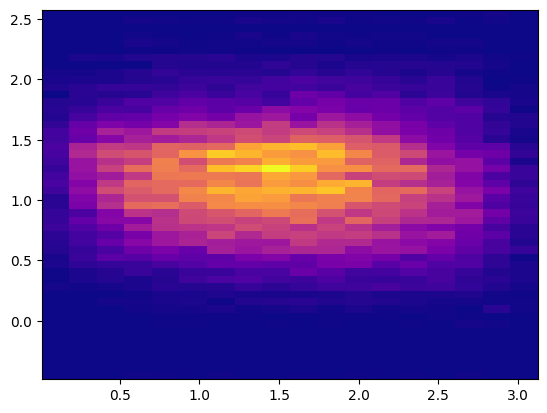

In [63]:
Background = plt.hist2d(psi_scrambled,np.log10(E_reco_oversample),bins =[18,50],cmap="plasma", density=True)

In [64]:
Bgd_psi_edges = np.histogram_bin_edges(psi_scrambled, bins=len(psi_scrambled))
Bgd_mass_edges = np.log10(np.histogram_bin_edges(E_reco, bins=len(E_reco_oversample)))

In [65]:
sys.path.append("/home/dvaldenaire/Python/Analysis/DMfit/DMfit")

from modeling import PdfBase, Model, Parameter
from data_DM import DataSet
from llh import LikelihoodRatioTest

In [66]:
SignalPDF = PdfBase(RecoRate_nue.flatten()/np.sum(RecoRate_nue), name='signal pdf')

In [67]:
BackgndPDF = PdfBase((Background[0].flatten())/np.sum(Background[0]), name='background')

In [68]:
RecoRate_nue.shape

(18, 50)

In [69]:
dm_H1 = Parameter(value=0., limits=(0,1), fixed=False, name='dm_H1')
dm_H0 = Parameter(value=0., limits=(0,1), fixed=True, name='dm_H0')

In [70]:
modelH1 = dm_H1*SignalPDF + (1-dm_H1)*BackgndPDF
modelH0 = dm_H0*SignalPDF + (1-dm_H0)*BackgndPDF

Parameter dm_H1 already exists in the model, it won't be added again
Parameter dm_H0 already exists in the model, it won't be added again


In [71]:
print(modelH1)

 Model: dm_H1*signal pdf + (1-dm_H1) * background
 Number of pdf: 2
 - signal pdf
 - background
 Number of parameters: 1
 Name: dm_H1, Value: 0.00, Scale: 1.0e+00, Limits: (0.0, 1.0), Fixed: False, Is nuisance? False


In [93]:
pseudo_data = 0.95*BackgndPDF + 0.05*SignalPDF

In [ ]:
# varying injection signal fraction and for each value of ksi repeat 100 or 1000 times 
# for each ksi return median percentile or quantile ?
# and start do the variation 

In [87]:
ds = DataSet()
ds.asimov(len(DEC_oversample), pseudo_data)
# ds.sample = refluctuate the data with Poisson - see how the fluctuations affect the results 

In [88]:
lr = LikelihoodRatioTest(model = modelH1, null_model = modelH0)

In [89]:
lr.data = ds #inject data in the likelihood model

In [90]:
lr.fit('H1')
lr.fit('H0')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.206e+05                 │               Nfcn = 1               │
│ EDM = -1.21e+05 (Goal: 0.0001)   │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ dm_H0 │    0.0    │    0.1    │            │            │    0    │    1    │  yes  │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────┐
│       │ dm_H0 │
├───────┼───────┤
│ dm_H0 │     0 │
└───────┴───────┘

In [91]:
print(lr.models['H1'].parameters['dm_H1'].value)

0.049998849105404045


In [92]:
lr.TS

11.038282431254629